# Data Loading and Transformation from Matrices to Link Counts


# New Section

make sure to upload data (ie "od-demand-202010-150.npy", od_stop, od_time,etc) from local machine to google colab notebook instance by clicking on "upload files", on the left. They must be re-uploaded every time the notebook instance is closed and re-opened. However, it doesn't take a long time to transform all the data.   

In [138]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle




def load_data(fp = '', pickle = False):
    data = np.load(fp, allow_pickle = pickle )
    return data

# def load_stop_data(fp=''):
#     data = pickle.load(fp)
#     return data

def transform_matrix(matrix):
    """
    Assuming matrix is 10x10
    """
    link_counts = []
    for i in range(len(matrix)-1):
        sum = np.sum(matrix[0:i+1, i+1:])
        link_counts.append(sum)

    return link_counts

def transform_all(matrices):
    all_counts = []
    for i in range(len(matrices)):
        count = transform_matrix(matrices[i])
        all_counts.append(count)
    return all_counts
    


demand_matrices = load_data('od-demand-202010-150.npy')

stop_names = load_data('od_stop-202010-150.npy', pickle = True)
print("bus stops: ", stop_names[0:10])

dates = load_data('od_time-202010-150.npy')
dates.shape = [np.shape(dates)[0], 1]
print("dimensions of date data: ", np.shape(dates))

# Finally we transform the data from matrices to link counts
route_counts = transform_all(demand_matrices)
print("dimension of transformed matrices: ", np.shape(route_counts))












bus stops:  ['KDST' 'EGEV' 'HHLS' 'HHM' 'GLHO' 'NÆST' 'KLBV' 'RYST' 'HKP' 'NPST1']
dimensions of date data:  (5786, 1)
dimension of transformed matrices:  (5786, 9)


#Basic Plotting and Data Visualization

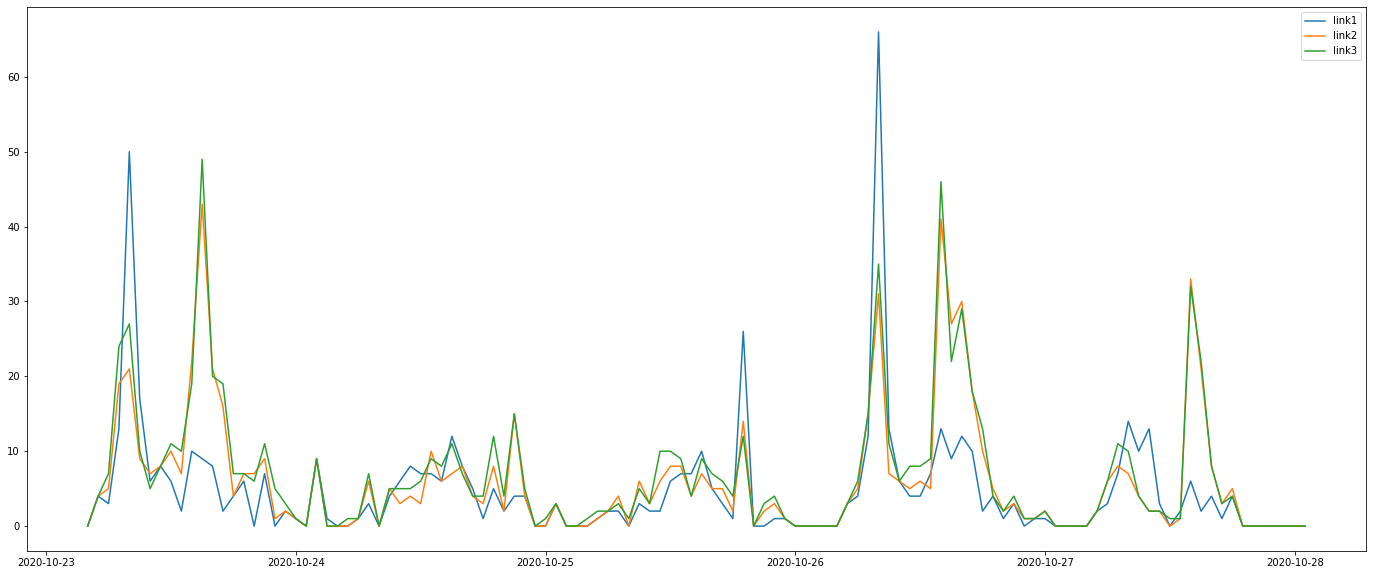

[0, 1, 2]


In [139]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def date_to_string(dates):
    date = ""
    new_dates = []
    for d in dates:
        date = str(d)[2:15]
        new_dates.append(date)
    return new_dates


def transform_to_plot_data(route_counts, start, stop):
    """ Transforms the route counts to a format that can be easily 
        plotted and visualized.
        We create a time series of data (in 1 hour intervals) for each link.
    """
    if not stop <= np.shape(route_counts)[0]:
        print("Error- interval end longer than route count matrix")
        return -1

    link_dict = {}
    for i in range(np.shape(route_counts)[1]):
        links = []
        link_num = i+1

        for j in range(start, stop):
            links.append(route_counts[j][i])

        link_dict[link_num] = links

    return link_dict


def plot_route_counts(route_counts, start, stop, links = range(len(route_counts[1])), plot_type = 'line'):
    """
    Plot the counts at each link over a given time interval.
    When entering in the links you wish to plot, subtract 1. 
    i.e. links = [0,1,2] if you wish to plot links 1, 2, 3.
    It's just an indexing thing. 
    """


    link_dict = transform_to_plot_data(route_counts, start, stop)
    fig = plt.figure(figsize=(24,10))
    
    if plot_type == 'line':
        for i in links:
            plt.plot(dates[start:stop], link_dict[i+1], label='link'+str(i+1))
    elif plot_type == 'bar':

        for i in links:
            plt.bar(list(np.arange(start, stop)), list(link_dict[i+1]))
            plt.xticks(np.arange(start, stop), date_to_string(dates[start:stop]), rotation = 90)

    plt.legend()
    plt.show()
    


links = [0,1,2]
plot_route_counts(route_counts, 5668, 5786, links)
print(links)



In [140]:
from sklearn.preprocessing import MinMaxScaler

def shuffle_in_unison(X, Y):
    n_elem = X.shape[0]
    indeces = np.random.permutation(n_elem)
    return X[indeces], Y[indeces]

X = np.array(route_counts) 
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(X)
X = scaler.transform(X)

look_back = 20
len_sequence = look_back
batch_size = 100
len_data = X.shape[0]
data = []
# create all possible sequences of length seq_len
for index in range(len_data - look_back): 
    data.append(X[index: index + look_back])
data = np.array(data)

X = data[:len_data,:-1,:]
Y = data[:len_data,-1,:]

num_features = X.shape[2]

# X, Y = shuffle_in_unison(X, Y)




In [141]:
class Dataset():
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(X, Y, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len_data*p_train)
    num_val = int(len_data*p_val)
    num_test = int(len_data*p_test)

    # Get inputs and targets for each partition
    inputs_train, targets_train = X[:num_train], Y[:num_train]  
    inputs_val, targets_val = X[num_train:num_train+num_val], Y[num_train:num_train+num_val]
    inputs_test, targets_test = X[-num_test:], Y[-num_test:]

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set


training_set, validation_set, test_set = create_datasets(X, Y, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 4628 samples in the training set.
We have 578 samples in the validation set.
We have 578 samples in the test set.


In [142]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
def load_dataset():

    trainloader = torch.utils.data.DataLoader(
      dataset = training_set,
      batch_size= batch_size,
      num_workers = 0,
      shuffle= True
    )

    validationloader = torch.utils.data.DataLoader(
      dataset = validation_set,
      batch_size= batch_size,
      num_workers= 0,
      shuffle= True
    )

    testloader = torch.utils.data.DataLoader(
      dataset = test_set,
      batch_size= batch_size,
      num_workers= 0,
      shuffle= False
    )

    return trainloader, validationloader, testloader

trainloader, validationloader, testloader = load_dataset()

In [143]:


class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        
        # Recurrent layer
        # YOUR CODE HERE!
        self.lstm = nn.LSTM(input_size=num_features,
                         hidden_size=30,
                         num_layers=2,
                         bidirectional=False,
                         batch_first = True,
                         dropout = 0.6)
        
        # Output layer
        self.l_out = nn.Linear(in_features=30,
                            out_features=num_features,
                            bias=False)
        
    def forward(self, x):
        # RNN returns output and last hidden state
        # print(len(x.size()))
        # if len(x.size()) == 2:
        #   batch_size = 1
        # else:
        batch_size = x.shape[0]

        # x = x.view(batch_size , -1, 1)
        # x = x.permute(1, 0, 2)
        x, (h, c) = self.lstm(x)
        
        # Flatten output for feed-forward layer
        x = x.contiguous().view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x)
        x = torch.Tensor.reshape(x, (batch_size, len_sequence - 1, num_features))
        x = x[:, -1, :]
        return x

net = MyRecurrentNet()
net = net.float()
print(net)

MyRecurrentNet(
  (lstm): LSTM(9, 30, num_layers=2, batch_first=True, dropout=0.6)
  (l_out): Linear(in_features=30, out_features=9, bias=False)
)


In [144]:
# Hyper-parameters
num_epochs = 100

# Initialize a new network
net = MyRecurrentNet()

# Define a loss function and optimizer for this problem
# YOUR CODE HERE!
#criterion = nn.MSELoss()
criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(net.parameters(), lr=0.003)

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    net.eval()
        
    # For each sentence in validation set
    for _,(inputs, targets) in enumerate(validationloader):
        batch = inputs.shape[0]

        inputs= inputs.float()
        targets = targets.float()
        # Forward pass
        outputs = net(inputs)
        # Compute loss
        loss = criterion(outputs, targets)
        # Update loss
        epoch_validation_loss += loss.detach().numpy() * batch
    
    net.train()
    
    # For each sentence in training set
    for _,(inputs, targets) in enumerate(trainloader):
        batch = inputs.shape[0]

        inputs = inputs.float()
        targets = targets.float()
        # Forward pass
        outputs = net(inputs)
        
        # Compute loss
        # YOUR CODE HERE!
        loss = criterion(outputs, targets)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update loss
        epoch_training_loss += loss.detach().numpy() * batch
        
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')



Epoch 0, training loss: 0.01189310845090664, validation loss: 0.037704853360318806
Epoch 10, training loss: 0.0034093801328604887, validation loss: 0.004054002267240859
Epoch 20, training loss: 0.0030362288353484937, validation loss: 0.0038101880869161092
Epoch 30, training loss: 0.00282411259927448, validation loss: 0.003441813111040986
Epoch 40, training loss: 0.0027495307850674785, validation loss: 0.003095185840953541
Epoch 50, training loss: 0.002513650045291478, validation loss: 0.0033465045420485178
Epoch 60, training loss: 0.0024495961992979666, validation loss: 0.0031968092201052033
Epoch 70, training loss: 0.0023593071659192984, validation loss: 0.0030979166809585474
Epoch 80, training loss: 0.0024328999353738544, validation loss: 0.0030126725202651895
Epoch 90, training loss: 0.0023084166065315648, validation loss: 0.0031381312847962427


Test Error: 0.0037513451639041165


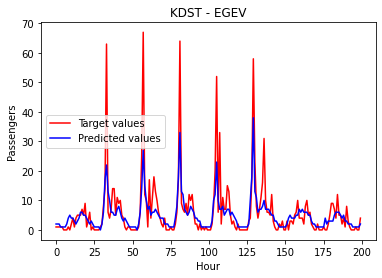

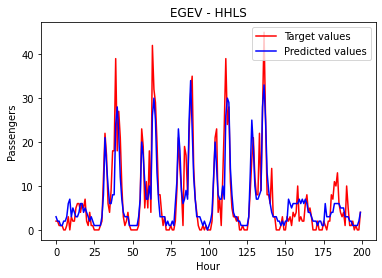

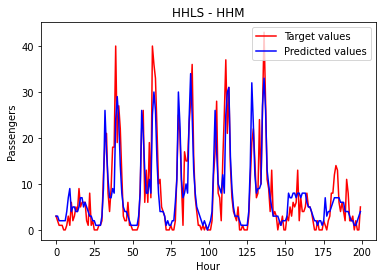

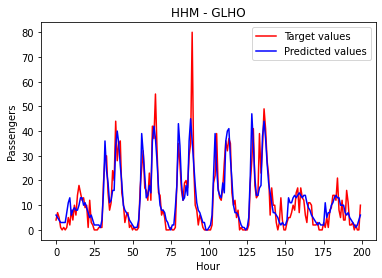

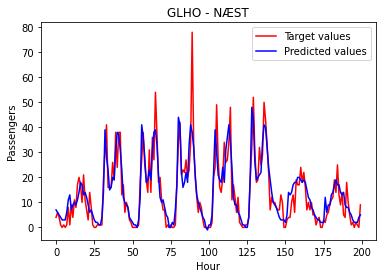

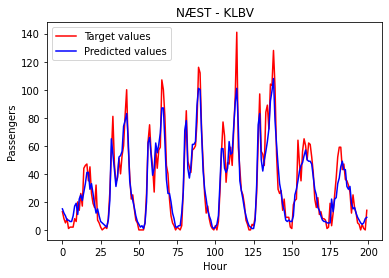

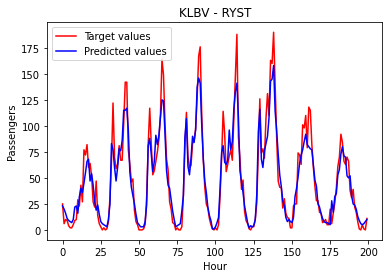

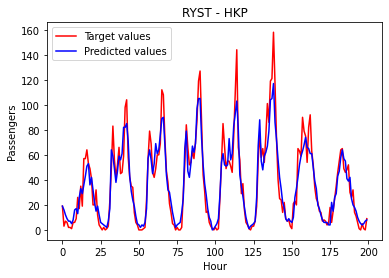

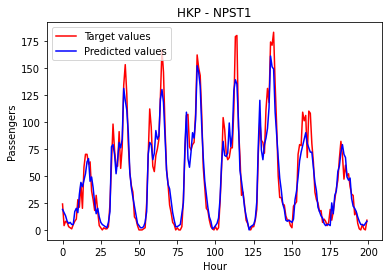

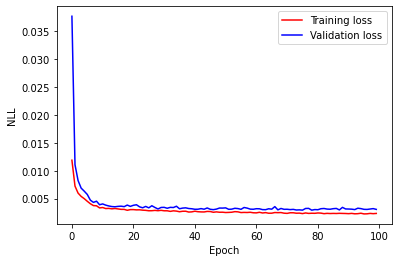

In [166]:
targets_test = []
outputs_test = []
targets_test_normalized = []
outputs_test_normalized = []

def series_criterion_error(forecast, actual):
    # find criterion error just like in training, for the test series 
 
    if len(forecast) and len(actual) <= 0:
        raise ValueError("forecast and actual series must be longer than 0")
 
    forecast = torch.tensor(forecast)
    actual = torch.tensor(actual)
    mse = 0
    for i in range(forecast.shape[0]):
        loss = criterion(forecast[i], actual[i])
        mse += loss.item()
 
    mse = mse/forecast.shape[0]    
    return mse

# Get first sentence in test set
for _,(inputs, targets) in enumerate(testloader):
  inputs = inputs.float()
  targets = targets.float()
  targets_test_normalized += targets.tolist()
  targets = np.round(scaler.inverse_transform(targets))
  targets_test = targets_test + targets.tolist()
  # Forward pass
  # output = np.round(net.forward(inputs).data.numpy())
  output = net.forward(inputs).data.numpy()
  outputs_test_normalized += output.tolist()
  output = np.round(scaler.inverse_transform(output))
  outputs_test = outputs_test + output.tolist()

print("Test Error: " + str(series_criterion_error(outputs_test_normalized, targets_test_normalized)))

# Reduce the size to show better in plot
MAX_HOURS = 200
targets_test = targets_test[:MAX_HOURS]
outputs_test = outputs_test[:MAX_HOURS]

for i in range(0,num_features):
  hour = np.arange(len(targets_test))
  title = stop_names[i] + " - " +stop_names[i+1]
  plt.figure()
  plt.plot(hour, [link[i] for link in targets_test], 'r', label='Target values',)
  plt.plot(hour, [link[i] for link in outputs_test], 'b', label='Predicted values')
  plt.legend()
  plt.xlabel('Hour'), plt.ylabel('Passengers')
  plt.title(title)
  plt.show()

# Plot training and validation loss
epoch = np.arange(len(training_loss))

plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()



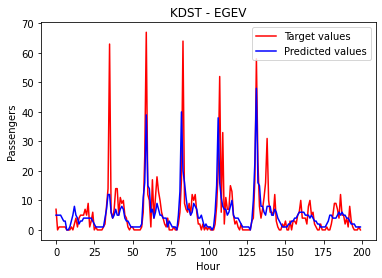

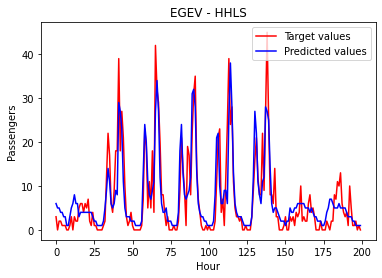

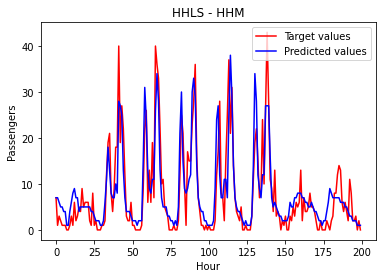

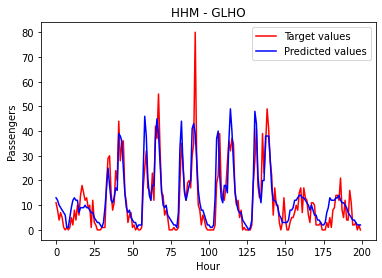

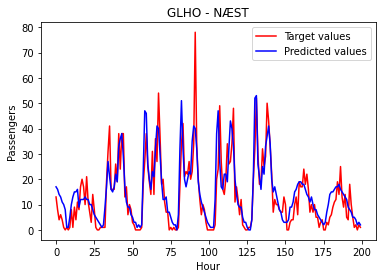

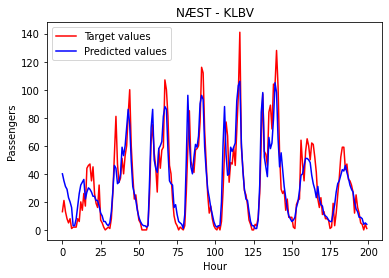

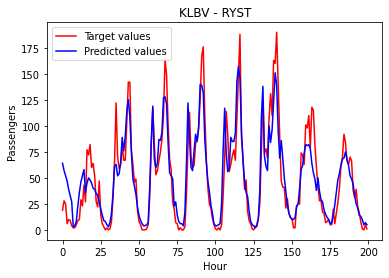

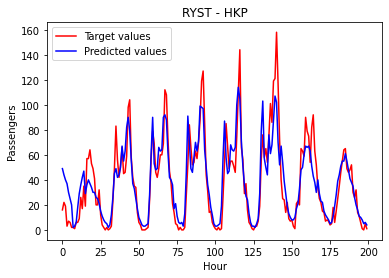

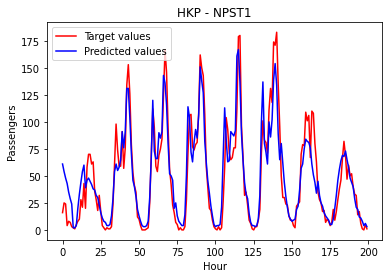

In [159]:
def extrapolate(X, start, num_steps):
    """
    Based on a single input sequence of length 19, it predicts the next output value y.
    This output is then used as part of the input for the next prediction sequence. 
 
    TO DO: Need to reset the hidden state to zero before making each new extrapolation. 
    """
    # X[start-20]
    
    start_seq = X[start]
    
    outputs_test = []
    # convert input to float tensor and reshape
    start_seq = torch.tensor(start_seq)
    start_seq = start_seq.float()
    start_seq = torch.Tensor.reshape(start_seq, (1, start_seq.shape[0], start_seq.shape[1]))
 
    for i in range(1, num_steps+1):
        # refresh buffer with new actual data every 8 steps
        if not i%8:
            new_input = X[start+i-20]
            start_seq = torch.tensor(new_input)
            start_seq = start_seq.float()
            start_seq = torch.Tensor.reshape(start_seq, (1, start_seq.shape[0], start_seq.shape[1]))
        
        # Forward pass
        output = net.forward(start_seq).data.numpy()
        
        output = torch.from_numpy(output)        
 
        #reshape the output
        output = torch.Tensor.reshape(output, (1, output.shape[0], output.shape[1]))
        
        # append output to last step of input, remove the first step of input
        new_input = start_seq[0,1:,:]
  
        #reshape the input
        new_input = torch.Tensor.reshape(new_input, (1, new_input.shape[0], new_input.shape[1]))
  
        new_input = torch.cat((new_input, output),dim=1)
        
        start_seq = new_input
 
        outputs_test = outputs_test + output.tolist()
    
    reformatted_outputs = []
    for row in outputs_test:
        reformatted_outputs.append(row[0])
    return reformatted_outputs

start = 5205
num_steps = 200

pred = extrapolate(X, start, num_steps)
pred = np.round(scaler.inverse_transform(pred))
def plot_extrapolation(pred, actual):
    for i in range(0,len(pred[0])):
        hour = np.arange(len(pred))
        title = stop_names[i] + " - " +stop_names[i+1]
        plt.figure()
        plt.plot(hour, [row[i] for row in actual], 'r', label='Target values',)
        plt.plot(hour, [row[i] for row in pred], 'b', label='Predicted values')
        plt.legend()
        plt.xlabel('Hour'), plt.ylabel('Passengers')
        plt.title(title)
        plt.show()
actual = route_counts[start:start+num_steps]
plot_extrapolation(pred, actual)
